# CVPR Workshop Figs

## Imports and loading data from wandb

In [7]:
import pandas as pd
import wandb
import src.viz as viz
import geomstats.backend as gs
import numpy as np
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.geometry.discrete_surfaces import (
    DiscreteSurfaces,
    ElasticMetric,
    _ExpSolver,
)
import plotly.io as pio
import matplotlib.pyplot as plt
import pyvista as pv

import src.setcwd
import src.datasets.utils as data_utils
import src.datasets.synthetic as synthetic
import project_regression.default_config as default_config

src.setcwd.main()
import os

my_28brains_dir = os.path.dirname(os.getcwd())
print("my28brains_dir: ", my_28brains_dir)

Working directory:  /Users/adelemyers/code/my28brains/src
Directory added to path:  /Users/adelemyers/code/my28brains
Directory added to path:  /Users/adelemyers/code/my28brains/src
Directory added to path:  /Users/adelemyers/code/my28brains/H2_SurfaceMatch
Directory added to path:  /Users/adelemyers/code/my28brains/src/notebooks
Directory added to path:  /Users/adelemyers/code/my28brains/src/notebooks/csv
my28brains_dir:  /Users/adelemyers/code/my28brains


In [2]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("bioshape-lab/my28brains-project_regression")

model_name = "model_2"

if model_name == "model_4":
    start_date = pd.to_datetime("2023-02-21")
    end_date = pd.to_datetime("2024-04-03")
else: 
    start_date = pd.to_datetime("2023-04-03")
    end_date = pd.to_datetime("2024-04-11")

desired_tags = {model_name}
undesirable_tags = {"old_PLS"}

summary_list, config_list, name_list = [], [], []
for run in runs: 
    run_tags = set(run.tags)
    
    if pd.to_datetime(run.createdAt) > start_date and desired_tags.issubset(run_tags) and not undesirable_tags.issubset(run_tags):
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)
    
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
              if not k.startswith('_')})
    
        # .name is the human-readable name of the run.
        name_list.append(run.name)

summary_df = pd.DataFrame.from_dict(
    summary_list)
config_df = pd.DataFrame.from_dict(
    config_list)
name_df = pd.DataFrame.from_dict(
    name_list)

runs_df = pd.concat([summary_df, config_df, name_df], axis = 1)

save_path = os.path.join(my_28brains_dir, f"project_regression/notebooks/csv/CVPRW/{model_name}.csv")

runs_df.to_csv(save_path)

# Choose which model to analyze

In [121]:
COL_TO_TEXT = {
    "diff_seq_per_time_vertex_diameter": "Error per mesh per vertex [% diameter]",
    "diff_seq_duration_per_time_and_vertex": "Time difference [secs] per mesh and vertex",
    "relative_diff_seq_duration": "Time difference per vertex [% line]",
    "n_steps": "Number of steps",
    "n_vertices": "Number of vertices",
    "rmsd": "RMSD",
    "rmsd_linear": "RMSD",
    "rmsd_geodesic": "RMSD",
    "rmsd_diameter": "RMSD, Line vs. Geodesic (per diameter)",
    "speed": "Speed gain",
    "accuracy": "Accuracy",
    "linear_residuals": "Regression",
    "linear_noise": "Noise",
    "geodesic_coef_err": "Geodesic Coef Error",
    "geodesic_duration_time": "Geodesic Duration Time",
    "noise_factor": "Noise Factor",
    "rmsd_geod": "RMSD, Geodesic Regression",
    "nrmsd_geod": "Normalized RMSD, Geodesic Regression",
    "n_X": "Number of Points",
    "n_geod_iterations": "Number of iterations in GR",
    "estimator": "Estimator",
    "estimator_duration_time": "Estimator Duration Time",
    "estimator_coef_err_sum": "Estimator coef error sum",
    "estimator_intercept_err_sum": "Estimator intercept error sum",
    "model_1": "Manifold Gaussian Noise",
    "model_2": "Euclidean Gaussian Noise",
    "model_3": "Projected Euclidean Gaussian Noise",
    "model_4": "Deformed Euclidean Gaussian Noise",
    "hypersphere": "Hypersphere",
    "hyperboloid": "Hyperboloid",
    "synthetic_mesh": "Synthetic Mesh",
}

In [212]:
######### EDIT ME ###############################################################

model_name = "model_1"
dataset_name = "synthetic_mesh"
# dataset_name = "hypersphere"
dataset_name = "hyperboloid"

# x_label = "n_X"
x_label = "noise_factor"

y_label = "rmsd"
y_label = "estimator_duration_time"

################################################################################################

path = os.path.join(my_28brains_dir, f"project_regression/notebooks/csv/CVPRW/{model_name}.csv")

df = pd.read_csv(path)
df = df.dropna(axis=1, how='all')
df = df.drop_duplicates()

df = df[df["dataset_name"] == dataset_name]

if dataset_name is not "synthetic_mesh":
    fixed_labels = ["n_X", "synthetic_tan_vec_length", "space_dimension"]
else:
    fixed_labels = ["n_X"]
    df = df[df["noise_factor"] != 0.4]
    df = df[df["noise_factor"] != 0.6]

if model_name in ["model_1", "model_3", "model_4"]: #,
    estimators = ["GLS", "LLS", "PLS", "Lin2015", "LR"]
    if y_label is "rmsd":
        y_label = "rmsd_geodesic"
elif model_name in ["model_2"]:
    estimators = ["LLS", "PLS", "Lin2015", "LR"]
    if y_label is "rmsd":
        y_label = "rmsd_linear"

fixed_value_dictionary = {
    "n_X": 30,
    "synthetic_tan_vec_length": 10,
    "space_dimension": 2,
    "noise_factor": 0.4,
}

df.head()

,Unnamed: 0,estimator_coef_hat,lr_intercept_err_sum,model,rmsd_geodesic,estimator_intercept_err,estimator_intercept_hat,estimator_intercept_err_norm,lr_coef_err_norm,estimator_coef_err_sum,...,dataset_name,linear_noise.1,noise_factor.1,space_dimension,project_linear_noise,synthetic_tan_vec_length.1,n_steps,end_shape,start_shape,0
360,360,"[6.098893207986617, 7.723732297376466, 11.6446...",3.252634,1.0,2.633829,"[0.1134160926078156, 0.13885751220304954, 0.22...","[1.1763254880466187, 0.5726376831783286, 0.236...",0.290141,4.841773,-22.042130,...,hyperboloid,False,0.6,2.0,False,10.0,NaN,NaN,NaN,run_zzxv3t7u
361,361,"[9.681989999565737, 12.971402295206776, 20.082...",6.820880,1.0,5.487253,"[0.11333673372280084, 0.14127759562888909, 0.2...","[1.165137568478287, 0.5645367155212387, 0.1970...",0.321267,17.008790,-45.911520,...,hyperboloid,False,0.6,2.0,False,10.0,NaN,NaN,NaN,run_oc8k0kxp
362,362,"[7.300927675208518, 9.83044780322182, 14.10047...",4.010944,1.0,3.598663,"[0.11137421807248882, 0.13518211115650092, 0.2...","[1.170668758373271, 0.5723283851867226, 0.2071...",0.310132,7.649732,-30.167296,...,hyperboloid,False,0.6,2.0,False,10.0,NaN,NaN,NaN,run_37vpgqeg
363,363,"[5.703111047917361, 7.632865933113195, 11.4002...",3.073541,1.0,2.644064,"[0.11432587372894364, 0.14258020551284467, 0.2...","[1.1665985645078063, 0.5644986143815344, 0.205...",0.315485,4.971216,-21.963638,...,hyperboloid,False,0.6,2.0,False,10.0,NaN,NaN,NaN,run_goflemlg
364,364,"[12.9929414532548, 17.36174261768454, 25.57405...",9.517085,1.0,7.343227,"[0.10684249662946854, 0.12506228004968625, 0.2...","[1.1744008579354088, 0.5818561557426385, 0.201...",0.308836,25.394003,-62.334042,...,hyperboloid,False,0.6,2.0,False,10.0,NaN,NaN,NaN,run_e4h0x3ja


## 1. Box plots of averaged results

In [213]:
estimator_results_dict = {}
for estimator_name in estimators: 
    estimator_df = df[df["estimator"] == estimator_name]
    
    for fixed_label in fixed_labels:        
        estimator_df = estimator_df[estimator_df[fixed_label] == fixed_value_dictionary[fixed_label]]

    results_df = {}
    results_df["x"] = estimator_df[x_label].unique()
        
    averaged_y_array = []
    y_range_min = []
    y_range_max = []
    if dataset_name in ["hypersphere", "hyperboloid"]:
        for x_val in results_df["x"]: # calculate averages and ranges for experiments with same noise values
            same_noise_df = estimator_df[estimator_df[x_label] == x_val]
            
            y_experiements = same_noise_df[y_label].values
            averaged_y_array.append(gs.mean(y_experiements))
            y_range_max.append(np.max(y_experiements))
            y_range_min.append(np.min(y_experiements))
        averaged_y_array = gs.array(averaged_y_array)
        y_range_max = gs.array(y_range_max)
        y_range_min = gs.array(y_range_min)

    elif dataset_name in ["synthetic_mesh"]:
        # print(estimator_df)
        averaged_y_array = estimator_df[y_label]
        # print(averaged_y_array.shape)
        # range_y_array = gs.zeros(estimator_df[y_label].shape)
        y_range_max = gs.zeros(estimator_df[y_label].shape)
        y_range_min = gs.zeros(estimator_df[y_label].shape)
    

    results_df["y_mean"] = averaged_y_array
    results_df["y_range_min"] = y_range_min
    results_df["y_range_max"] = y_range_max
    results_df = pd.DataFrame.from_dict(results_df)
    
    estimator_results_dict[estimator_name] = results_df



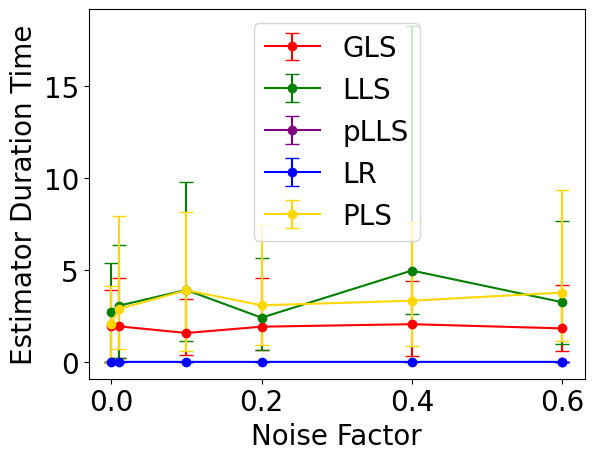

In [214]:
# Plotting the lines with error bars
if model_name is not "model_2":
    plt.errorbar(estimator_results_dict["GLS"]["x"], estimator_results_dict["GLS"]["y_mean"], yerr=(estimator_results_dict["GLS"]["y_range_min"], estimator_results_dict["GLS"]["y_range_max"]) , fmt='-o', color='red', label='GLS', capsize=5)
plt.errorbar(estimator_results_dict["LLS"]["x"], estimator_results_dict["LLS"]["y_mean"], yerr=(estimator_results_dict["LLS"]["y_range_min"], estimator_results_dict["LLS"]["y_range_max"]), fmt='-o', color='green', label='LLS', capsize=5)
plt.errorbar(estimator_results_dict["Lin2015"]["x"], estimator_results_dict["Lin2015"]["y_mean"], yerr=(estimator_results_dict["Lin2015"]["y_range_min"], estimator_results_dict["Lin2015"]["y_range_max"]), fmt='-o', color='purple', label='pLLS', capsize=5)
plt.errorbar(estimator_results_dict["LR"]["x"], estimator_results_dict["LR"]["y_mean"], yerr=(estimator_results_dict["LR"]["y_range_min"], estimator_results_dict["LR"]["y_range_max"]), fmt='-o', color='blue', label='LR', capsize=5)
if model_name is not "model_4":
    plt.errorbar(estimator_results_dict["PLS"]["x"], estimator_results_dict["PLS"]["y_mean"], yerr=(estimator_results_dict["PLS"]["y_range_min"], estimator_results_dict["PLS"]["y_range_max"]), fmt='-o', color='gold', label='PLS', capsize=5)

# Customizing the plot
plt.xlabel(COL_TO_TEXT[x_label])
plt.ylabel(COL_TO_TEXT[y_label])
# plt.title(f'{model_name} on {dataset_name}')
plt.legend()
plt.rcParams['font.size'] = 20

fig1 = plt.gcf()
# Show the plot
plt.show()

file_path = os.path.join(my_28brains_dir, f"project_regression/notebooks/figs/{model_name}_{dataset_name}_{y_label}_{x_label}.svg")
fig1.savefig(file_path, format = "svg")


## 2. 2D sphere showing the difference between: linear gaussian, manifold gaussian, projected gaussian, deformed gaussian noises

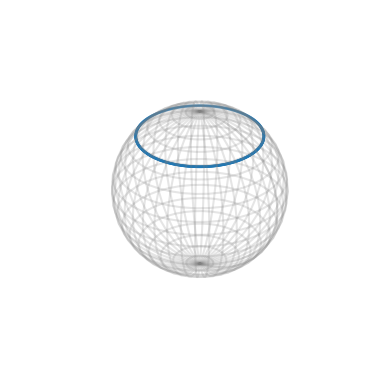

In [65]:
space = Hypersphere(dim=2)

# Riemannian Gaussian noise, aka, Geodesic noise
theta = gs.arange(0, 2*gs.pi, step = 0.01)

radius = 0.8
points_on_circle = [gs.array([radius*gs.cos(t), radius*gs.sin(t), 0.]) for t in theta]
points_on_circle = gs.array(points_on_circle)

points_on_level_set = space.metric.exp(points_on_circle, base_point=gs.array([0., 0., 1.]))

import geomstats.visualization as visualization


ax = visualization.plot(points_on_level_set, space="S2", s=1)
ax.grid(False)
ax.axis("off")

file_path = os.path.join(my_28brains_dir, "project_regression/notebooks/figs/gaussian_tangent_space_noise.svg")
fig = ax.get_figure()
fig.savefig(file_path)

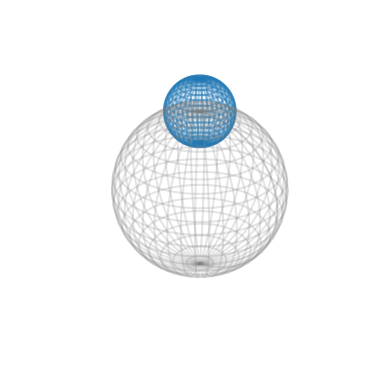

In [66]:
# Unprojected Eucliean Gaussian noise

n_meridians = 40
n_circles_latitude = 20


u, v = gs.meshgrid(
    gs.linspace(0.0, 2 * gs.pi, n_meridians + 1),
    gs.linspace(0.0, gs.pi, n_circles_latitude + 1),
)

center = north_pole = gs.array([0., 0., 1.])
radius = 0.4
sphere_x = center[0] + radius * gs.cos(u) * gs.sin(v)
sphere_y = center[1] + radius * gs.sin(u) * gs.sin(v)
sphere_z = center[2] + radius * gs.cos(v)

ax = visualization.plot(center, space="S2", s=1)
ax.grid(False)
ax.axis("off")
ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color="C0", alpha=0.4)

file_path = os.path.join(my_28brains_dir, "project_regression/notebooks/figs/euclidean_gaussian_noise.svg")
fig = ax.get_figure()
fig.savefig(file_path)

In [67]:
n_meridians = 2
n_circles_latitude = 2

u, v = gs.meshgrid(
    gs.linspace(0.0, 2 * gs.pi, n_meridians + 1),
    gs.linspace(0.0, gs.pi, n_circles_latitude + 1),
)

u

array([[0.        , 3.14159265, 6.28318531],
       [0.        , 3.14159265, 6.28318531],
       [0.        , 3.14159265, 6.28318531]])

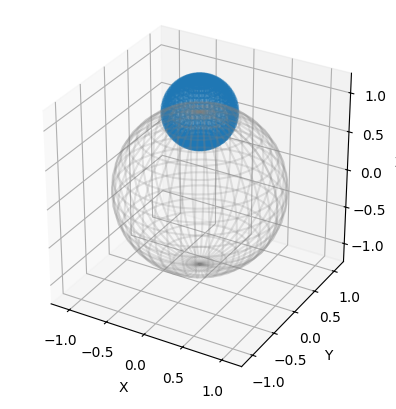

In [68]:
import itertools

n_meridians = 40
n_circles_latitude = 20

us = gs.linspace(0.0, 2 * gs.pi, n_meridians + 1)
vs = gs.linspace(0.0, gs.pi, n_circles_latitude + 1)

sphere_x = gs.array([center[0] + radius * gs.cos(u) * gs.sin(v) for u, v in itertools.product(us, vs)])
sphere_y = gs.array([center[1] + radius * gs.sin(u) * gs.sin(v) for u, v in itertools.product(us, vs)])
sphere_z = gs.array([center[2] + radius * gs.cos(v) for u, v in itertools.product(us, vs)])

ax = visualization.plot(center, space="S2", s=1)
ax.scatter(sphere_x, sphere_y, sphere_z, color="C0", alpha=0.4)



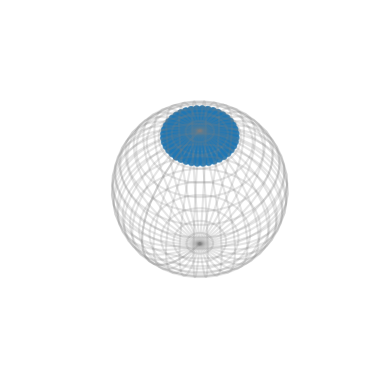

In [69]:
sphere_points = gs.vstack([sphere_x, sphere_y, sphere_z]).T
projected_points = space.projection(sphere_points)

ax = visualization.plot(center, space="S2", s=1)
ax.grid(False)
ax.axis("off")
ax.view_init(elev=50, azim = 40)
ax.scatter(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2], color="C0", alpha=0.4)

file_path = os.path.join(my_28brains_dir, "project_regression/notebooks/figs/projected_euclidean_gaussian_noise.svg")
fig = ax.get_figure()
fig.savefig(file_path)

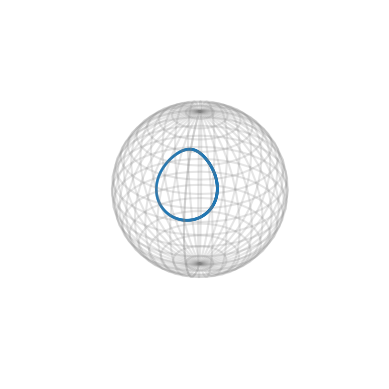

In [70]:

# Riemannian Gaussian noise, aka, Geodesic noise

us = gs.arange(0, 2*gs.pi, step = 0.01)

radius = 0.4
center = gs.array([1., 0.])
points_on_circle = [gs.array([radius*gs.cos(u) + center[0], radius*gs.sin(u)] + center[1]) for u in us]
points_on_circle = gs.array(points_on_circle)

points_extrinsic = space.intrinsic_to_extrinsic_coords(points_on_circle)

ax = visualization.plot(points_extrinsic, space="S2", s=1)
ax.view_init(azim=10)
ax.grid(False)
ax.axis("off")

file_path = os.path.join(my_28brains_dir, "project_regression/notebooks/figs/deformed_noise.svg")
fig = ax.get_figure()
fig.savefig(file_path)

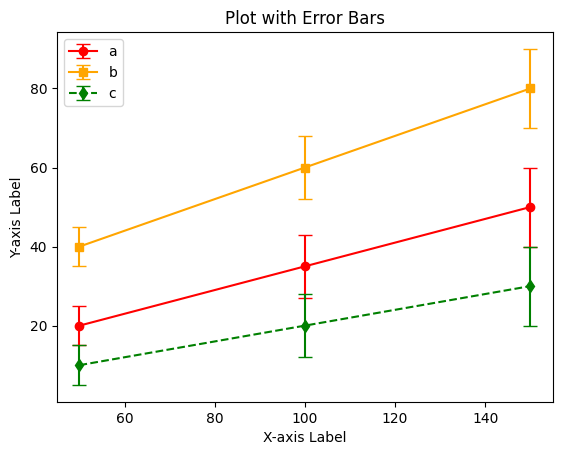